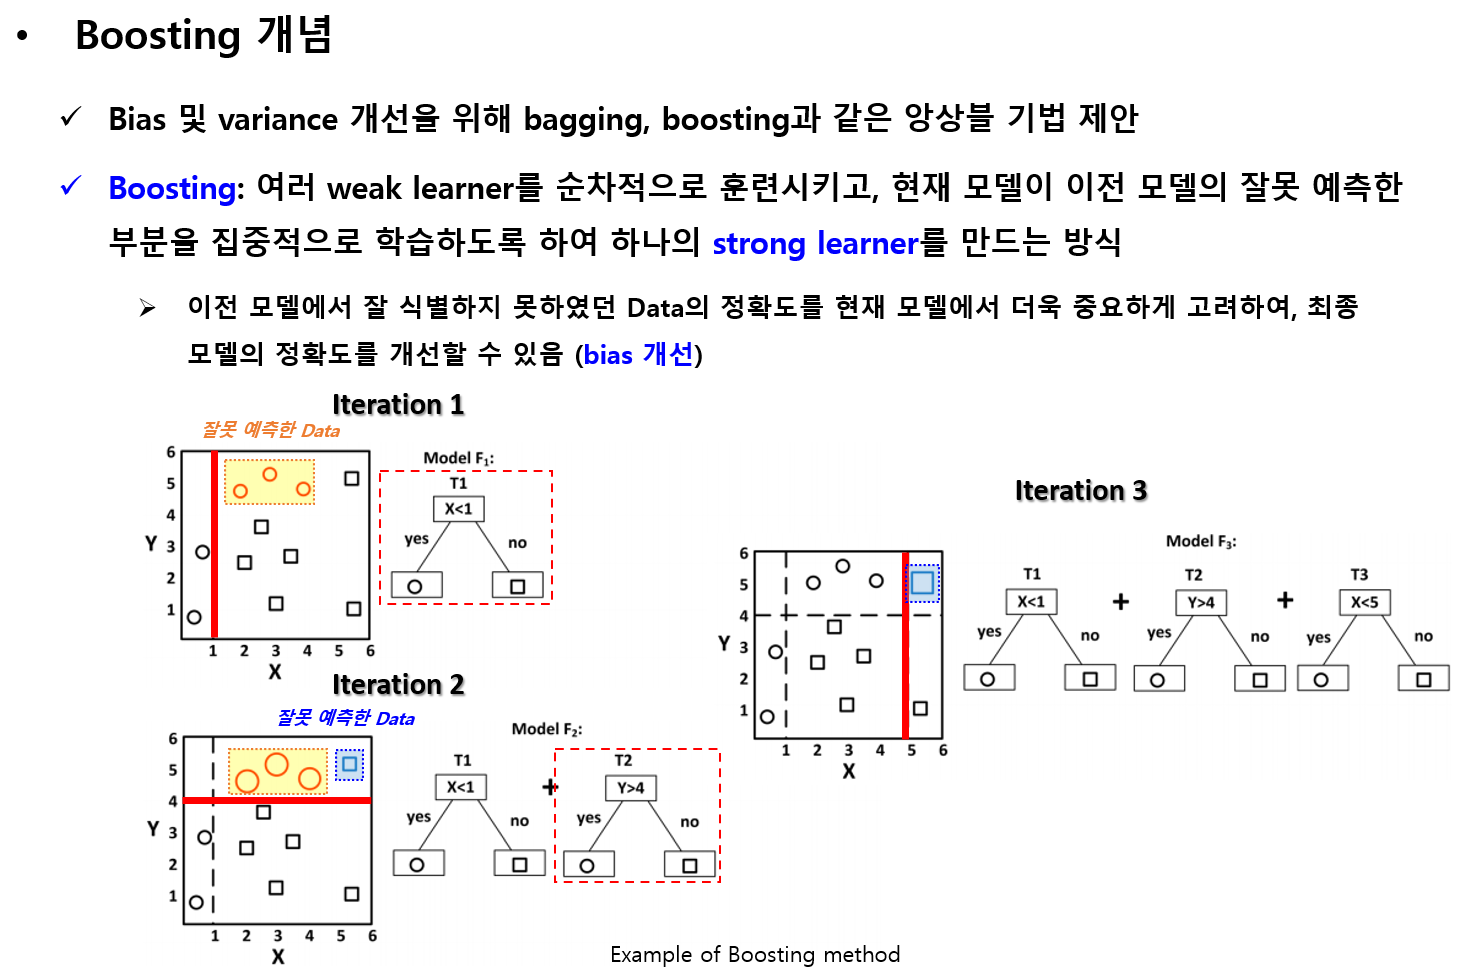

## **GBM (Regression): 발전소 전기 에너지 출력(PE) 예측**

In [ ]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/Yong-Gon/LG2025_Boosting.git #코랩 사용

In [ ]:
'''
CCPP Data : 6년 간(2006-2011) 발전소가 최대 부하로 작동할 때 시간당 순수 전기 에너지 출력(PE)를
평균 주변 온도(AT), 주변 압력(AP), 상대 습도(RH), 배기 진공(V) 센서 데이터를 이용해 예측하는 데이터
'''

# 데이터 불러오기
dt = pd.read_csv("/content/LG2025_Boosting/CCPP.csv", encoding = "UTF-8-sig")
dt.head(10)

In [ ]:
# 데이터 타입(type) 확인
dt.info()

In [ ]:
'''
결측치가 존재할 경우, 특정 값(0)으로 replace 가능
df.replace(np.nan,'0',inplace = True)
'''

# 데이터 결측치 확인
dt.isna().sum()

In [ ]:
# 데이터 분포(통계량) 확인
dt.describe()

In [ ]:
# 데이터 분포(그래프) 확인
sns.pairplot(dt)

In [ ]:
# 변수 별 상관계수
dt.corr()

In [ ]:
# 학습 데이터와 테스트 데이터 구분

# 학습 데이터 비율: 0.7, 테스트 데이터 비율: 0.3
train_data, test_data = train_test_split(dt, train_size = 0.7)

# 독립변수(Xs)와 종속변수(Y) 구분
train_X = train_data.iloc[:, :-1].reset_index(drop = True) # train_X에 종속변수 제거
train_Y = train_data.iloc[:, -1].reset_index(drop = True) # train_Y(종속변수) 따로 저장

test_X = test_data.iloc[:, :-1].reset_index(drop = True) # test_X에 종속변수 제거
test_Y = test_data.iloc[:, -1].reset_index(drop = True) # test_Y(종속변수) 따로 저장

In [ ]:
test_X.head()

In [ ]:
# GBM 모델(예측) package 불러오기
from sklearn.ensemble import GradientBoostingRegressor

#모델 파라미터 설정
'''
파라미터 목록: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
'''
model = GradientBoostingRegressor(loss          = "squared_error",
                                  learning_rate = 0.1,
                                  n_estimators  = 100,
                                  criterion     = "squared_error", # mse = squared_error
                                  max_depth     = 3,
                                  min_samples_split = 2,
                                  min_samples_leaf  = 1,
                                  verbose = 1)

#설정된 모델 파라미터에 데이터 fitting (GBM 학습)
model.fit(train_X, train_Y)

In [ ]:
# 학습한 GBM 모델을 통해 테스트 데이터 예측

# pred 변수에 실제값 추가
pred = pd.DataFrame(test_Y)

# 생성된 모델로 예측하기 / pred 변수에 예측값 추가
pred["pred"] = model.predict(test_X)

# 예측 결과 확인 (첫 10 instances)
pred.head(10)

- 예측 모델 평가지표

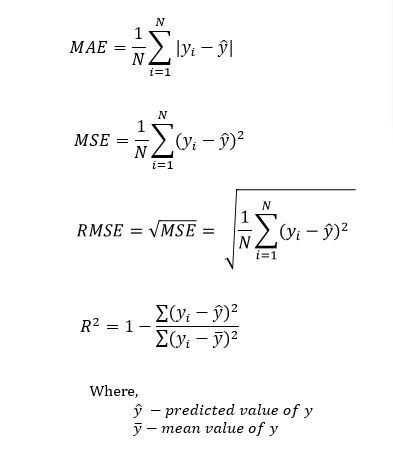

In [ ]:
# 예측 값과 실제 값 간의 오차 확인

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(pred.PE, pred.pred)
print("MAE : ", MAE)

# Mean Squared Error (MSE)
MSE = mean_squared_error(pred.PE, pred.pred)
print("MSE : ", MSE)

# Rooted Mean Squared Error (RMSE)
RMSE = np.sqrt(mean_squared_error(pred.PE, pred.pred))
print("RMSE : ", RMSE)

# 예측 값과 실제 값 간의 R^2(결정 계수) 계산
# 분산 기반으로 예측 성능을 평가 / 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울수록 예측 정확도가 높음
r2 = r2_score(pred.PE, pred.pred)
print("R-squared : ", r2)

In [ ]:
# 오차 Plot
plt.figure(figsize = (10, 7))
plt.title("GBM")
plt.scatter(pred.PE, pred.pred)
plt.xlabel("PE")
plt.ylabel("pred")
plt.show()

In [ ]:
# 500번의 반복(iteration)에 대해 예측 결과 할당

# 빈 공간의 ndarray 생성
test_score = np.zeros((100,), dtype=np.float64)

# 예측 값 (y_pred)와 실제 값 (y_test)의 loss를 test_score에 저장
# 학습이 진행될수록 loss값이 0에 가깝게 줄어드는 것을 확인할 수 있음
for i, y_pred in enumerate(model.staged_predict(test_X)):
    test_score[i] = mean_squared_error(test_Y, y_pred)

In [ ]:
# 500 iteration에 대한 학습 데이터 loss 값(파란선)과 테스트 데이터 loss 값(빨간선)을 확인할 수 있음
# 반복이 거듭될수록 loss값이 감소하며, 점차 0에 가까운 값으로 수렴함

fig = plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)
plt.title('Deviation')
plt.plot(np.arange(100) + 1, model.train_score_, 'b-', label='Training Set Deviation')
plt.plot(np.arange(100) + 1, test_score, 'r-', label='Test Set Deviation')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviation')
fig.tight_layout()
plt.show()

In [ ]:
# 의사결정나무 앙상블을 기반으로 하여, GBM 모델을 통해 변수 중요도 추출 가능

# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = model.feature_importances_

# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)

# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize=(8, 4))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(dt.columns)[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
plt.show()

## **GBM (Classification): 가입자 이탈 여부 예측**

In [ ]:
# 필요한 기본 package 불러오기
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/Yong-Gon/LG2025_Boosting.git #코랩 사용

In [ ]:
'''
가입자 이탈/이탈률 dataset : 전체 19개 피처와 1개의 타겟으로 구성 (Categorical feature: State, Area_code, Int.l.Plan, VMail.Plan)
타겟명: 'Churn.' / True(1)는 이탈한 고객, False(0)는 이탈하지 않은 고객을 의미함
'''

# 데이터 불러오기
dt2 = pd.read_csv("/content/LG2025_Boosting/churn.csv")
print('dataset shape:', dt2.shape)

# 데이터 확인
dt2.head()

In [ ]:
# 데이터 타입(type) 확인
dt2.info()

In [ ]:
# 데이터 전처리

# column name 중 "."을 "_"으로 변경
dt2.columns = dt2.columns.str.replace(".","_")

# data중 Area.Code는 지역숫자로 수치적 의미를 갖지 않으므로, category 형태로 변경
'''
- category: 가능한 값의 범위가 고정적 or 한정적일 때 사용 (ex. 아침식사 여부: 0, 1)
- object: 문자열이거나 범위가 한정적이지 않을 경우 사용   (ex. 아침식사 종류: 샐러드, 소고기, 바나나, 샌드위치 등)
'''
dt2.Area_Code = dt2.Area_Code.astype("category")

print(dt2['Churn_'].value_counts())

unsatisfied_cnt = dt2[dt2['Churn_'] == "True." ].Churn_.count()
total_cnt = dt2.Churn_.count()

print('\n이탈자 비율은 {0:.3f}'.format((unsatisfied_cnt / total_cnt))) # True: 이탈

In [ ]:
# 변경된 데이터 타입(type) 확인
dt2.info()

In [ ]:
# 독립변수(Xs)와 종속변수(Y) 구분
X_features = dt2.iloc[:, :-1]
y_labels = dt2.iloc[:, -1]

# 타겟 변수에 대해 불만족한 고객 ('True.')을 1로, 나머지는 0으로 해서 최종적으로 binary class {1, 0}로 변경
y_labels = np.where(y_labels == "True.", 1, 0)
y_labels = pd.Series(y_labels)

print('type of labels:{0}'.format(np.unique(y_labels)))

In [ ]:
# object 타입을 category로 변경
for col in X_features.columns:
    if X_features[col].dtypes == "O":
        X_features[col] = X_features[col].astype('category')

# 데이터 타입(type) 확인
X_features.info()

In [ ]:
# GBM에서 categorical feature에 대해 one-hot encoding 진행
def onehot(data, feature):

    return pd.concat([data, pd.get_dummies(data[feature], prefix=feature)], axis=1).drop([feature], axis=1)

# 다음 4가지 categorical feature에 대해 one-hot encoding을 진행 후 기존 X_feature에 결합
cate_list = ['State', 'Area_Code', 'Int_l_Plan', 'VMail_Plan']

for i in range(len(cate_list)):

    X_features = onehot(X_features, cate_list[i])

In [ ]:
# 추가된 feature 확인
X_features.info()

In [ ]:
# 학습 데이터와 테스트 데이터 구분
# 학습 데이터 비율: 0.8, 테스트 데이터 비율: 0.2
train_X, test_X, train_y, test_y = train_test_split(X_features, y_labels, test_size=0.2, random_state=0)
train_cnt = train_y.count()
test_cnt = test_y.count()

print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(train_X.shape , test_X.shape))

print('\n학습 세트 레이블 값 분포 비율')
print(train_y.value_counts()/train_cnt)

print('\n테스트 세트 레이블 값 분포 비율')
print(test_y.value_counts()/test_cnt)

In [ ]:
# GBM 모델 package 불러오기
from sklearn.ensemble import GradientBoostingClassifier

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

# 모델 생성 및 train data로 fitting (학습) 진행
clf = GradientBoostingClassifier(loss             = 'log_loss',
                                 criterion        = 'squared_error', # 개별 트리의 불순도 측도
                                 n_estimators     = 100,
                                 min_samples_leaf = 5,
                                 max_depth        = 3,
                                 learning_rate    = 1,
                                 random_state     = 0)
clf.fit(train_X , train_y)

# GBM 실험 종료에 대한 시간 측정
gb_time = time.time() - start_time
print("GBM 수행 시간: {0:.2f} 초 ".format(gb_time))

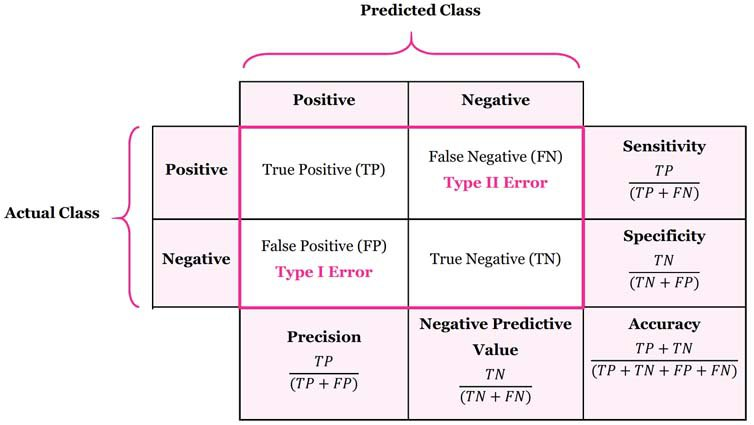

In [ ]:
# 학습 완료된 GBM 모델을 통해 테스트 데이터 예측
pred = clf.predict(test_X)

# 예측 값과 실제 값 간의 비교를 통해, 정확도(차이) 계산
accuracy = accuracy_score(test_y, pred)
print('GBM 정확도: {0:.4f}'.format(accuracy))

In [ ]:
# precision/recall/f1-score/accuracy 산출
print(classification_report(test_y, pred))

In [ ]:
# 예측 값과 실제 값 간의 비교를 통해, AUC 계산
roc_score = roc_auc_score(test_y, clf.predict_proba(test_X)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(roc_score))

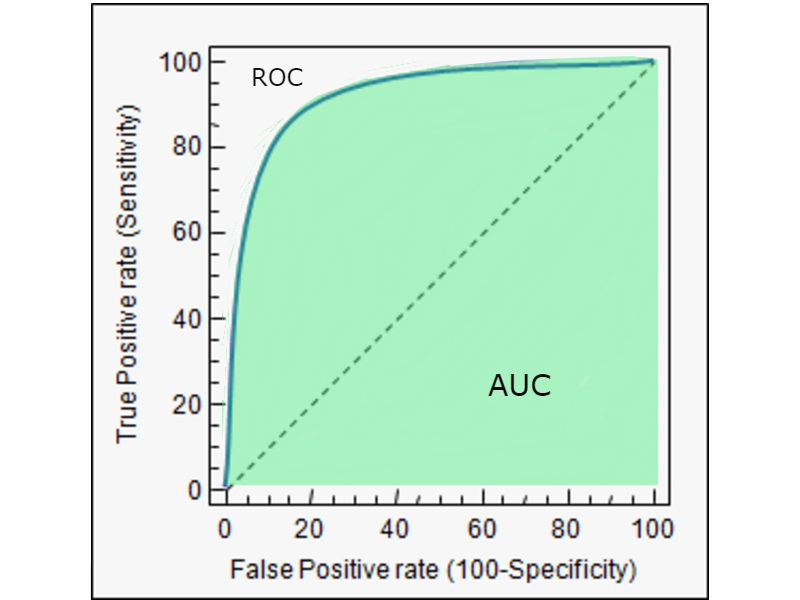

In [ ]:
# 의사결정나무 앙상블을 기반으로 하여, GBM 모델을 통해 변수 중요도 추출 가능

# feature importance 산출 / feature importance 값이 높을수록 feature 중요도가 높다고 해석할 수 있음
feature_importance = clf.feature_importances_

# feature_importance를 높은 순서로 정렬
sorted_idx = np.argsort(feature_importance)

# 변수 중요도 plot의 X축 길이를 선정하기 위한 설정
pos = np.arange(sorted_idx.shape[0]) + .5

fig = plt.figure(figsize = (10, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_features.columns)[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
plt.show()

In [ ]:
# 변수 중요도 (수치 확인)
for i, col in enumerate(dt2.iloc[:, :-1].columns):
    print(f'{col} 중요도 : {clf.feature_importances_[i]}')

print("\n", clf.get_params()) # GradientBoostingClassifier 클래스 인자 설정 정보

> GridSearch를 통한 파라미터 최적화

In [ ]:
# 최적 hyper parameter를 찾기 위해 GridSearchCV 실행
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 300, 500],
    'learning_rate' : [ 0.05, 0.1]
}

gb_grid_cv = GridSearchCV(clf , param_grid=params , cv=2 ,verbose=1, n_jobs=-1)
gb_grid_cv.fit(train_X , train_y)
print('최적 하이퍼 파라미터:\n', gb_grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(gb_grid_cv.best_score_))

In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 예측 수행
gb_pred = gb_grid_cv.best_estimator_.predict(test_X)
gb_accuracy = accuracy_score(test_y, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

gb_grid_cv_roc_score = roc_auc_score(test_y, gb_grid_cv.predict_proba(test_X)[:,1],average='macro')
print('GBM ROC AUC: {0:.4f}'.format(gb_grid_cv_roc_score))

> 개별 Tree 시각화

In [ ]:
# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

# 모델 생성 및 train data로 fitting (학습) 진행
clf = GradientBoostingClassifier(loss             = 'log_loss',
                                 criterion        = 'squared_error', # 개별 트리의 불순도 측도
                                 n_estimators     = 5,
                                 min_samples_leaf = 5,
                                 max_depth        = 3,
                                 learning_rate    = 1,
                                 random_state     = 0)
clf.fit(train_X , train_y)

# GBM 실험 종료에 대한 시간 측정
gb_time = time.time() - start_time
print("GBM 수행 시간: {0:.2f} 초 ".format(gb_time))

In [ ]:
from sklearn.tree import plot_tree

n_estimator = len(clf.estimators_)
fig = plt.figure(figsize=(20, 15), facecolor='white')

row_num=2
col_num=3
for i in range(n_estimator):
    ax = fig.add_subplot(row_num, col_num, i+1)
    plot_tree(clf.estimators_[i][0],
              feature_names=X_features.columns, ## 박스에 변수 이름 표시
              ax=ax
             )
    ax.set_title(f'{i+1}th Tree')
plt.show()